<a href="https://colab.research.google.com/github/mahi1038/Overstock-Liquidation-/blob/main/notebooks/SmartBinning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1> Smart Binning**

What is Smart Binning?

In simple language, grouping items together intelligently for clearance sales. Instead of putting all overstock items in random buckets,

Which items belong together in the same “bin” (because similar customers buy them).

Which bins are likely to clear faster based on price sensitivity, demand overlap, and local trends.

🎯 Example:

🥛 Milk and 🥣 Cereal → go in one smart bin because they are often bought together.

👗 Party dresses and 👠 heels → go in another bin for a different audience.

In [6]:
pip install hdbscan


HDBSCAN is like DBSCAN but smarter:

It automatically finds clusters of varying density.

Handles outliers gracefully without tuning eps.

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [8]:
final_df= pd.read_csv("train.csv")

In [9]:

# Encode store_id and state_id, basically turning them into numbers so our ML model can understand them. 1 for tx etc

final_df['store_encoded'] = LabelEncoder().fit_transform(final_df['store_id'])
final_df['state_encoded'] = LabelEncoder().fit_transform(final_df['state_id'])

# Features for clustering
features = final_df[[
    'sell_price', 'rolling_mean_28', 'price_pct_change',
    'store_encoded', 'state_encoded'
]].fillna(0)

# Scale features so all features contribute equally
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)




bin=-1 means SKUs are outliers (don’t belong to any smart bin).

In [10]:
best_persistence = 0
best_size = 50
'''

cluster_persistence_: How “strong” each cluster is
You can try multiple runs and maximize mean cluster persistence

'''

for size in range(20, 150, 10):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(scaled_features)
    avg_persistence = clusterer.cluster_persistence_.mean()

    if avg_persistence > best_persistence:
        best_persistence = avg_persistence
        best_size = size

print(f"Best min_cluster_size: {best_size}, Avg Persistence: {best_persistence:.2f}")


# Apply HDBSCAN -> Too low → Too many tiny clusters, noisy bins. Too high → Few giant clusters, you lose nuance.
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_size, prediction_data=True)
final_df['bin'] = clusterer.fit_predict(scaled_features)

# Outliers are labeled -1
print(final_df['bin'].value_counts())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best min_cluster_size: 20, Avg Persistence: 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


bin
-1      28879
 181      207
 127      198
 111      183
 317      182
        ...  
 124       21
 381       20
 259       20
 169       20
 341       20
Name: count, Length: 439, dtype: int64


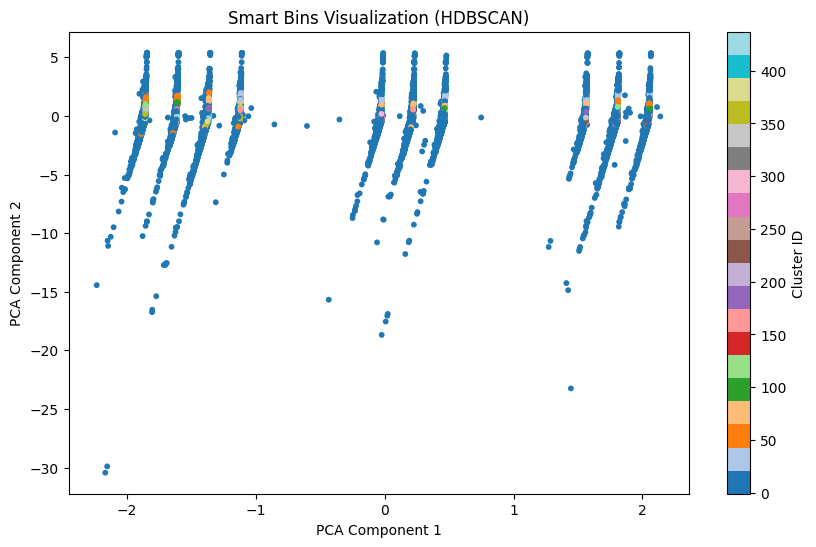

In [11]:
# Reduce to 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    reduced_features[:, 0], reduced_features[:, 1],
    c=final_df['bin'], cmap='tab20', s=10
)
plt.colorbar(label='Cluster ID')
plt.title('Smart Bins Visualization (HDBSCAN)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In our dataset, every SKU (product) has these properties:

Demand trends (recent sales, seasonality)

Price elasticity (how sensitive buyers are to price changes)

Location (state, store)

Customer preference overlap (items often bought together)

We can use clustering algorithms like K-Means or DBSCAN to group SKUs into "smart bins" based on these features. Each bin will then get its own clearance strategy (e.g., discount %, marketing to certain buyers, etc.).

In [12]:
# Group SKUs into bins by store and state
bin_summary = (
    final_df.groupby(['bin', 'state_id', 'store_id'])
    .agg({
        'item_id': 'count',
        'sell_price': 'mean',
        'rolling_mean_28': 'mean'
    })
    .rename(columns={'item_id': 'num_items'})
    .reset_index()
)

# Save bin summary
bin_summary.to_csv('smart_bins_summary.csv', index=False)

# Save SKU to bin mapping
final_df[['item_id', 'store_id', 'state_id', 'bin']].to_csv('sku_bin_mapping.csv', index=False)

print("✅ Smart bins created and saved!")


✅ Smart bins created and saved!


We want features that determine similarity for clearance:

sell_price

rolling_mean_28 (recent sales trends)

price_pct_change (price sensitivity)

dept_id (to keep related products together)

state_id (location effect)

 Score Smart Bins for Clearance Priority
We’ll assign a priority score for each bin:

📉 Low Sales Trend → Higher Priority

💲 High Price Elasticity → Higher Priority

📦 Few Items Left → Higher Priority



In [13]:
def score_bins(final_df):
    """
    Scores bins for clearance priority
    """
    bin_scores = (
        final_df[final_df['bin'] != -1]  # exclude outliers
        .groupby('bin')
        .agg({
            'rolling_mean_28': 'mean',  # avg recent sales
            'price_pct_change': 'mean',  # price sensitivity
            'item_id': 'count'           # SKU count
        })
        .rename(columns={'item_id': 'num_items'})
        .reset_index()
    )

    # Calculate priority score (lower sales & higher price change = higher score)
    bin_scores['priority_score'] = (
        (1 / (bin_scores['rolling_mean_28'] + 1)) * 0.5 +
        bin_scores['price_pct_change'].abs() * 0.3 +
        (1 / (bin_scores['num_items'] + 1)) * 0.2
    )

    # Sort by priority
    bin_scores = bin_scores.sort_values(by='priority_score', ascending=False)
    return bin_scores


In [14]:
bin_scores = score_bins(final_df)
print(bin_scores)

     bin  rolling_mean_28  price_pct_change  num_items  priority_score
328  328              0.0               0.0         21        0.509091
386  386              0.0               0.0         21        0.509091
124  124              0.0               0.0         21        0.509091
134  134              0.0               0.0         21        0.509091
288  288              0.0               0.0         21        0.509091
..   ...              ...               ...        ...             ...
234  234              NaN               0.0         22             NaN
314  314              NaN               0.0         24             NaN
322  322              NaN               0.0         27             NaN
377  377              NaN               0.0         31             NaN
399  399              NaN               0.0         23             NaN

[438 rows x 5 columns]


Simulate Clearance Campaigns

This step predicts bin clearance success under different discounts.

In [19]:
def simulate_clearance(final_df, bin_scores, discount_levels=[0.1, 0.2, 0.3, 0.5]):
    """
    Simulate clearance campaigns by applying discounts
    and estimating revenue for each bin at multiple discount levels.
    """
    results = []

    for discount in discount_levels:
        for bin_id in bin_scores['bin']:
            # Filter SKUs in this bin
            bin_data = final_df[final_df['bin'] == bin_id].copy()

            # Handle NaNs: replace missing price elasticity with 0 (no effect)
            price_elasticity = bin_data['price_pct_change'].fillna(0).mean()

            # If rolling_mean_28 is missing, assume 0 sales
            bin_data['rolling_mean_28'] = bin_data['rolling_mean_28'].fillna(0)

            # Simulate increased sales due to discount
            simulated_sales = bin_data['rolling_mean_28'] * (1 + price_elasticity * discount * 10)

            # Ensure no negative simulated sales
            simulated_sales = simulated_sales.clip(lower=0)

            # Calculate total revenue after applying discount
            discounted_price = bin_data['sell_price'] * (1 - discount)
            total_revenue = (discounted_price * simulated_sales).sum()

            results.append({
                'bin': bin_id,
                'discount': discount,
                'simulated_revenue': round(total_revenue, 2)
            })

    # Combine results into a DataFrame
    campaign_df = pd.DataFrame(results)
    return campaign_df


In [22]:
# Run simulation
campaign_results = simulate_clearance(final_df, bin_scores)

In [24]:
# Filter and print only rows where revenue is NOT zero
non_zero_revenue = campaign_results[campaign_results['simulated_revenue'] > 0]

print("📈 Bins where simulated revenue > 0:")
print(non_zero_revenue.head(10))  # Show top 10 rows


📈 Bins where simulated revenue > 0:
     bin  discount  simulated_revenue
58   200       0.1               0.09
71   375       0.1               0.05
91   404       0.1               0.06
112  292       0.1               0.17
120  323       0.1               0.06
125  308       0.1               0.09
126  419       0.1               0.09
127  199       0.1               0.11
132  427       0.1               0.06
138  137       0.1               0.53


In [23]:
print(campaign_results.head())


   bin  discount  simulated_revenue
0  328       0.1                0.0
1  386       0.1                0.0
2  124       0.1                0.0
3  134       0.1                0.0
4  288       0.1                0.0


Scoring Bins

✅ After binning, you summarize each bin in bin_scores.

This calculates for each bin:

Average sales (rolling_mean_28)

Average price change (price_pct_change)

Number of SKUs (num_items)



In [27]:
# Score bins
bin_scores = score_bins(final_df)

Simulate Clearance Campaigns

✅ Here you run simulations like:

“If I apply a 10% discount to Bin 0, how much revenue will I make?”

“What if I try 50% discount on Bin 1?”

The output campaign_results shows predicted revenues for different discount levels per bin.

In [28]:
# Simulate clearance campaigns
campaign_results = simulate_clearance(final_df, bin_scores)

In [29]:
# Run Smart Binning
# final_df, clusterer = smart_binning_pipeline(final_df, min_cluster_size=50)



# Save results
bin_scores.to_csv('bin_priority_scores.csv', index=False)
campaign_results.to_csv('clearance_campaign_results.csv', index=False)

print("✅ Smart Binning, Scoring, and Campaign Simulation Complete!")


✅ Smart Binning, Scoring, and Campaign Simulation Complete!


In [25]:
def suggest_clearance_strategy(bin_summary_df):
    """
    Suggest clearance strategy for each bin based on avg price, sales, and elasticity.

    Args:
        bin_summary_df (pd.DataFrame): DataFrame with columns
            ['bin', 'avg_price', 'avg_sales', 'price_elasticity', 'num_skus']

    Returns:
        pd.DataFrame: Original DataFrame with added 'clearance_strategy' column
    """
    strategies = []

    for _, row in bin_summary_df.iterrows():
        price = row['avg_price']
        sales = row['avg_sales']
        elasticity = row['price_elasticity']
        skus = row['num_skus']

        # Strategy logic
        if sales == 0:
            strategy = "50% discount, push locally"
        elif elasticity > 0.5:
            strategy = "20% discount, online only"
        elif price < 100 and sales < 5:
            strategy = "30% discount, combo offers"
        elif price >= 100 and sales >= 5:
            strategy = "10% discount, push to app users"
        else:
            strategy = "25% discount, experiment with flash sales"

        strategies.append(strategy)

    bin_summary_df['clearance_strategy'] = strategies
    return bin_summary_df


✅ What does suggest_clearance_strategy() expect?
This function is designed to take a bin summary DataFrame (like bin_scores or bin_summary_df) that contains one row per bin with the following information:

bin	rolling_mean_28	price_pct_change	num_items	priority_score

It uses these columns to decide:

Which bins are dead stock (e.g., zero sales)

Which bins are price sensitive (high elasticity)

Which bins have steady sales but could benefit from moderate discounts

And then assigns a clearance strategy for each bin.

In [30]:

# Suggest clearance strategies
bin_scores = suggest_clearance_strategy(bin_scores)

# Print results
print(bin_scores[['bin', 'clearance_strategy']])


KeyError: 'avg_price'

🔥 Why not final_df?
❌ final_df contains SKU-level data (thousands of rows).

✅ suggest_clearance_strategy() expects bin-level data (1 row per bin).

So you must pass bin_scores.